In [1]:
# importing all needed library
import pandas as pd 
import seaborn as sns 
import re, nltk
nltk.download('punkt')
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
plt.style.use('fivethirtyeight')
plt.style.use('dark_background')
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import Embedding 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# accessing drive content
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# mounting dataset from path
data = '/content/drive/MyDrive/Kuliah/Semester 7/Pembelajaran Mesin/Final Exam/dataset/Tweets.csv' 
df = pd.read_csv(data)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# showing colums from the dataset
df.columns 

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [5]:
# showing sum data in the dataset
df.isnull().sum() 

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

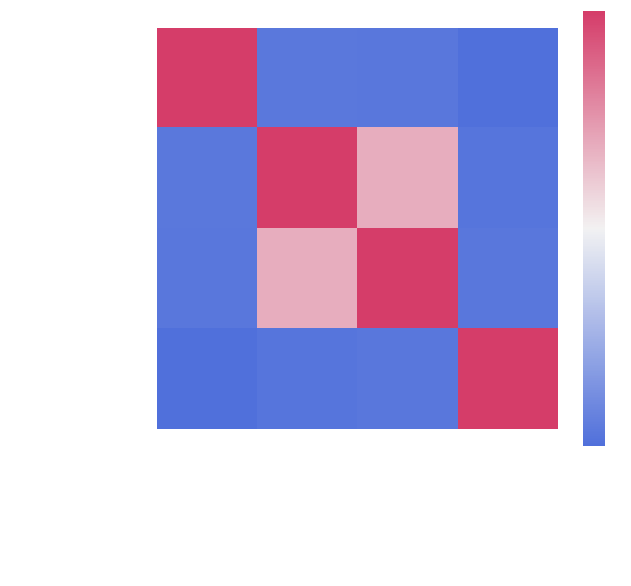

In [6]:
# ploting 8x8 figure
plt.figure(figsize = (8,8)) 
corr = df.corr()
sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) , cmap=sns.diverging_palette(-100,0,as_cmap=True) , square = True)

In [7]:
# dropping the unused columns from the dataset
unused_data = df[['tweet_id', 'negativereason', 'negativereason_confidence', 'airline_sentiment_gold', 'negativereason_gold', 'tweet_coord', 'tweet_location', 'user_timezone', 'name', 'retweet_count', 'tweet_created']]
df = df.drop(columns=unused_data)
df

,airline_sentiment,airline_sentiment_confidence,airline,text
0,neutral,1.0000,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,0.3486,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,Virgin America,@VirginAmerica and it's a really big bad thing...
...,...,...,...,...
14635,positive,0.3487,American,@AmericanAir thank you we got on a different f...
14636,negative,1.0000,American,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,1.0000,American,@AmericanAir Please bring American Airlines to...
14638,negative,1.0000,American,"@AmericanAir you have my money, you change my ..."


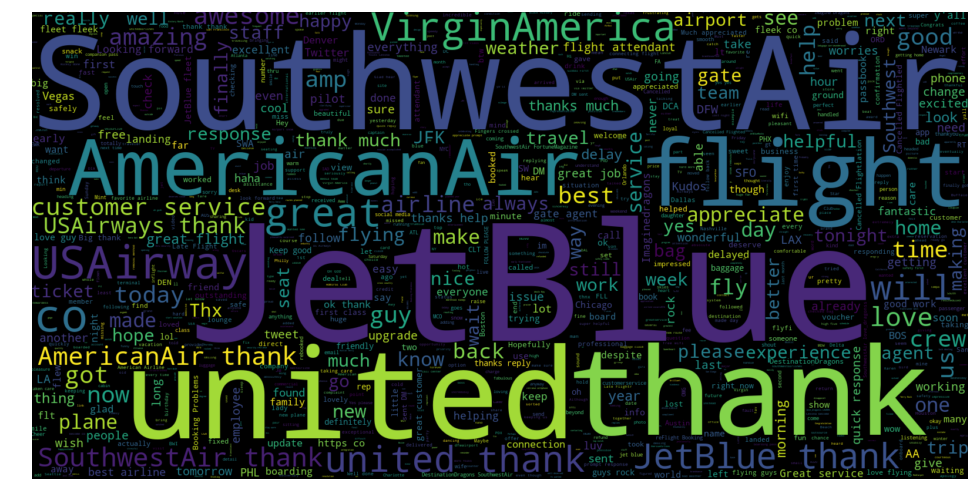

In [8]:
# plotting 15x15 positive sentiment
plt.figure(figsize = (15,15)) 
plt.grid(False)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.airline_sentiment == 'positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

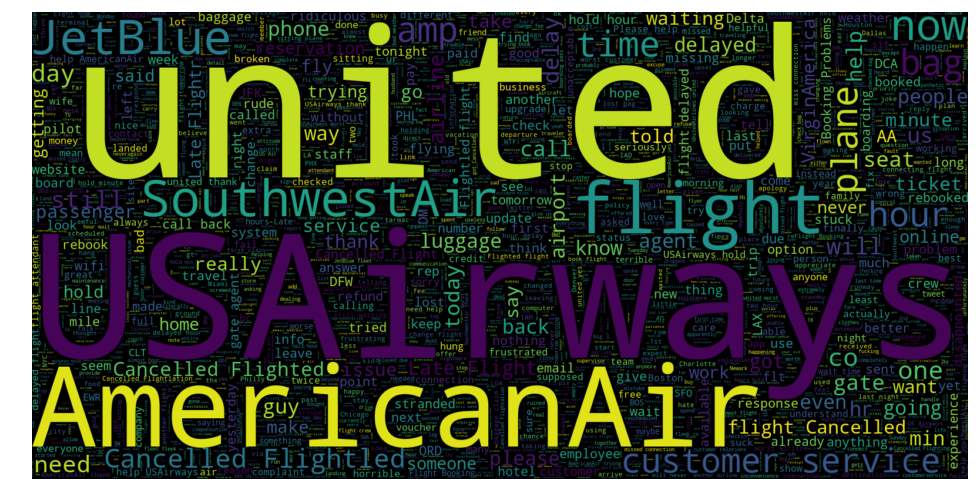

In [9]:
# plotting 15x15 negative sentiment
plt.figure(figsize = (15,15))
plt.grid(False)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.airline_sentiment == 'negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

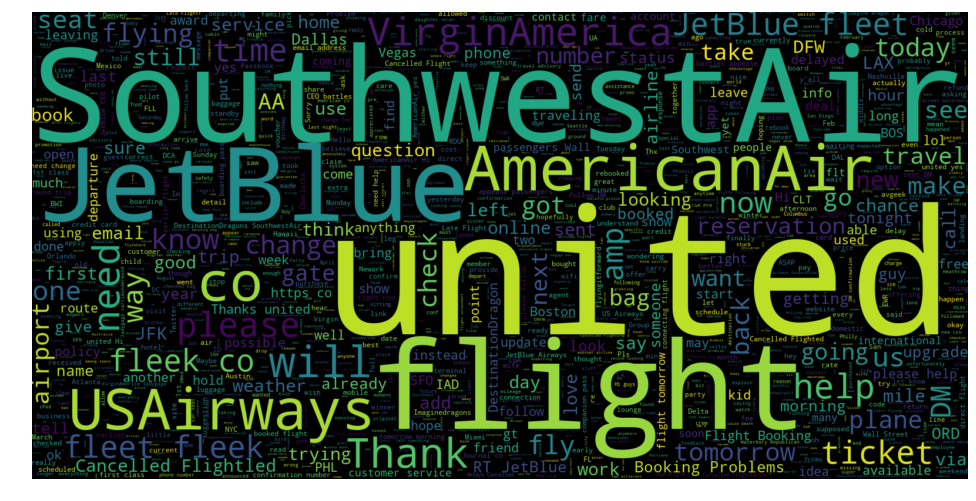

In [10]:
# plotting 15x15 neutral sentiment
plt.figure(figsize = (15,15))
plt.grid(False)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.airline_sentiment == 'neutral'].text))
plt.imshow(wc , interpolation = 'bilinear')

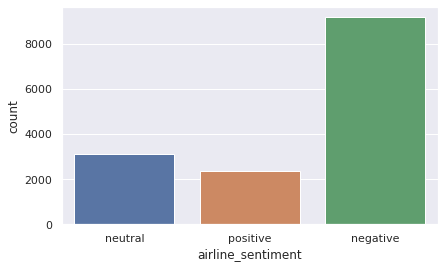

In [11]:
# showing count grap
sns.set(style="darkgrid") 
sns.countplot(x = "airline_sentiment" , data = df)

In [12]:
# define clean function and create the model
def clean_the_tweet(text):
  tokens= nltk.word_tokenize(re.sub("[^a-zA-Z]", " ",text))
  tokens = [token.lower() for token in tokens]
  return ' '.join(tokens[2:])

def text_process(msg):
  nopunc =[char for char in msg if char not in string.punctuation]
  nopunc=''.join(nopunc)
  return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])
 
def check_scores(clf, X_train, X_test, y_train, y_test):
  model = clf.fit(X_train, y_train)
  predicted_class = model.predict(X_test)
  predicted_class_train = model.predict(X_train)
  test_probs = model.predict_proba(X_test)
  test_probs = test_probs[:, 1]
  yhat = model.predict(X_test)
  lr_precision, lr_recall, _ = precision_recall_curve(y_test, test_probs)
  lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)


  print('Train confusion matrix is: ',)
  print(confusion_matrix(y_train, predicted_class_train))
  print()

  print('Test confusion matrix is: ')
  print(confusion_matrix(y_test, predicted_class))
  print()

  print(classification_report(y_test,predicted_class)) 
  print() 

  train_accuracy = accuracy_score(y_train,predicted_class_train)
  test_accuracy = accuracy_score(y_test,predicted_class)

  print("Train accuracy score: ", train_accuracy)
  print("Test accuracy score: ",test_accuracy )
  print()
  
  train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
  test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

  print("Train ROC-AUC score: ", train_auc)
  print("Test ROC-AUC score: ", test_auc)
  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.plot(lr_recall, lr_precision)
  ax1.set(xlabel="Recall", ylabel="Precision")

  plt.subplots_adjust(left=0.5,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
  print()
  print('Are under Precision-Recall curve:', lr_f1)
  
  fpr, tpr, _ = roc_curve(y_test, test_probs)


  ax2.plot(fpr, tpr)
  ax2.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

  print("Area under ROC-AUC:", lr_auc)
  return train_accuracy, test_accuracy, train_auc, test_auc



def grid_search(model, parameters, X_train, Y_train):
  #Doing a grid
  grid = GridSearchCV(estimator=model,
                       param_grid = parameters,
                       cv = 2, verbose=2, scoring='roc_auc')
  #Fitting the grid 
  grid.fit(X_train,Y_train)
  print()
  print()
  # Best model found using grid search
  optimal_model = grid.best_estimator_
  print('Best parameters are: ')
  print( grid.best_params_)

  return optimal_model

In [13]:
# applying the clean function
df = df[df['airline_sentiment']!='neutral']
df['cleaned_tweet'] = df['text'].apply(clean_the_tweet)

df.head()
df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: 1 if x =='positive' else 0)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,airline_sentiment,airline_sentiment_confidence,airline,text,cleaned_tweet
1,1,0.3486,Virgin America,@VirginAmerica plus you've added commercials t...,you ve added commercials to the experience tacky
3,0,1.0000,Virgin America,@VirginAmerica it's really aggressive to blast...,s really aggressive to blast obnoxious enterta...
4,0,1.0000,Virgin America,@VirginAmerica and it's a really big bad thing...,it s a really big bad thing about it
5,0,1.0000,Virgin America,@VirginAmerica seriously would pay $30 a fligh...,would pay a flight for seats that didn t have ...
6,1,0.6745,Virgin America,"@VirginAmerica yes, nearly every time I fly VX...",nearly every time i fly vx this ear worm won t...


In [14]:
# cleaning the text
df['cleaned_tweet'] = df['cleaned_tweet'].apply(text_process)
df.reset_index(drop=True, inplace = True)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,airline_sentiment,airline_sentiment_confidence,airline,text,cleaned_tweet
0,1,0.3486,Virgin America,@VirginAmerica plus you've added commercials t...,added commercials experience tacky
1,0,1.0000,Virgin America,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
2,0,1.0000,Virgin America,@VirginAmerica and it's a really big bad thing...,really big bad thing
3,0,1.0000,Virgin America,@VirginAmerica seriously would pay $30 a fligh...,would pay flight seats playing really bad thin...
4,1,0.6745,Virgin America,"@VirginAmerica yes, nearly every time I fly VX...",nearly every time fly vx ear worm go away


In [15]:
# showing array wih value 1 and 0
df['airline_sentiment'].unique() 

array([1, 0])

In [16]:
# preprocessing with tf-idf
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(df.cleaned_tweet)
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df['airline_sentiment'], random_state=42)

In [17]:
# artificial neural network
corpus = [df['cleaned_tweet'][i] for i in range( len(df))]

voc_size=5000

onehot_=[one_hot(words,voc_size)for words in corpus] 

max_sent_length=max([len(i) for i in corpus])

embedded_docs=pad_sequences(onehot_,padding='pre',maxlen=max_sent_length)

model=Sequential()
model.add(Dense(512, input_dim = max_sent_length, activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X_final=np.array(embedded_docs)
y_final=np.array(df['airline_sentiment'])
X_final.shape, y_final.shape

((11541, 124), (11541,))

In [18]:
# testing data from epoch
X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X_final, y_final, test_size=0.3, random_state=42)
model.fit(X_train_NN, y_train_NN, validation_data = (X_test_NN, y_test_NN), epochs=10, batch_size=64)

Epoch 1/10
127/127 [==============================] - 1s 5ms/step - loss: 0.4921 - accuracy: 0.7971 - val_loss: 0.4662 - val_accuracy: 0.8129
Epoch 2/10
127/127 [==============================] - 1s 4ms/step - loss: 0.4764 - accuracy: 0.8027 - val_loss: 0.4634 - val_accuracy: 0.8146
Epoch 3/10
127/127 [==============================] - 0s 4ms/step - loss: 0.4726 - accuracy: 0.8049 - val_loss: 0.4643 - val_accuracy: 0.8158
Epoch 4/10
127/127 [==============================] - 0s 4ms/step - loss: 0.4745 - accuracy: 0.8038 - val_loss: 0.4641 - val_accuracy: 0.8114
Epoch 5/10
127/127 [==============================] - 1s 4ms/step - loss: 0.4702 - accuracy: 0.8055 - val_loss: 0.4635 - val_accuracy: 0.8137
Epoch 6/10
127/127 [==============================] - 1s 4ms/step - loss: 0.4708 - accuracy: 0.8029 - val_loss: 0.4630 - val_accuracy: 0.8123
Epoch 7/10
127/127 [==============================] - 1s 4ms/step - loss: 0.4689 - accuracy: 0.8056 - val_loss: 0.4634 - val_accuracy: 0.8114
Epoch 

In [19]:
# testing model
y_test_pred_NN=np.round(model.predict(X_test_NN))
y_train_pred_NN=np.round(model.predict(X_train_NN))
y_test_pred_NN

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [20]:
# testing model
test_acc_NN = accuracy_score(y_test_NN, y_test_pred_NN)
train_acc_NN = accuracy_score(y_train_NN, y_train_pred_NN)
test_roc_NN = roc_auc_score(y_test_NN, y_test_pred_NN)
train_roc_NN = roc_auc_score(y_train_NN, y_train_pred_NN)

In [21]:
# lstm
corpus = [df['cleaned_tweet'][i] for i in range( len(df))]

voc_size=5000

onehot_=[one_hot(words,voc_size)for words in corpus] 

max_sent_length=max([len(i) for i in corpus])

embedded_docs=pad_sequences(onehot_,padding='pre',maxlen=max_sent_length)
    
embedding_vector_features=64
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_sent_length))
model.add(Dropout(0.4))
model.add(LSTM(128))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X_final=np.array(embedded_docs)
y_final=np.array(df['airline_sentiment'])
X_final.shape,y_final.shape

((11541, 124), (11541,))

In [22]:
# testing data from epoch using lstm
X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(X_final, y_final, test_size=0.3, random_state=42)
model.fit(X_train_LSTM, y_train_LSTM, validation_data = (X_test_LSTM, y_test_LSTM), epochs=10, batch_size=64)

Epoch 1/10
127/127 [==============================] - 40s 295ms/step - loss: 0.4451 - accuracy: 0.8180 - val_loss: 0.3266 - val_accuracy: 0.8542
Epoch 2/10
127/127 [==============================] - 37s 291ms/step - loss: 0.2459 - accuracy: 0.8958 - val_loss: 0.2795 - val_accuracy: 0.8891
Epoch 3/10
127/127 [==============================] - 37s 290ms/step - loss: 0.1834 - accuracy: 0.9280 - val_loss: 0.3129 - val_accuracy: 0.8810
Epoch 4/10
127/127 [==============================] - 37s 291ms/step - loss: 0.1566 - accuracy: 0.9410 - val_loss: 0.3478 - val_accuracy: 0.8773
Epoch 5/10
127/127 [==============================] - 37s 291ms/step - loss: 0.1230 - accuracy: 0.9562 - val_loss: 0.4189 - val_accuracy: 0.8758
Epoch 6/10
127/127 [==============================] - 37s 291ms/step - loss: 0.1058 - accuracy: 0.9627 - val_loss: 0.4063 - val_accuracy: 0.8646
Epoch 7/10
127/127 [==============================] - 37s 290ms/step - loss: 0.0901 - accuracy: 0.9674 - val_loss: 0.4955 - val_ac

Train confusion matrix is: 
[[6853    2]
 [1296  504]]

Test confusion matrix is: 
[[2318    5]
 [ 474   89]]

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2323
           1       0.95      0.16      0.27       563

    accuracy                           0.83      2886
   macro avg       0.89      0.58      0.59      2886
weighted avg       0.85      0.83      0.78      2886


Train accuracy score:  0.8500288850375506
Test accuracy score:  0.834026334026334

Train ROC-AUC score:  0.9561105438041981
Test ROC-AUC score:  0.9013005324009118

Are under Precision-Recall curve: 0.2709284627092846
Area under ROC-AUC: 0.7374839454006489


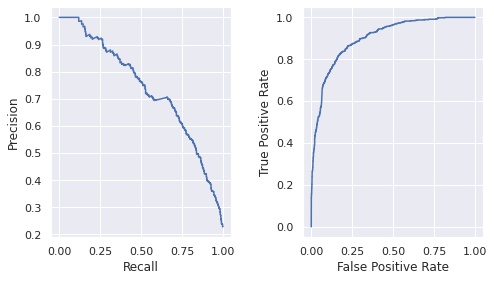

In [23]:
# multinomial naive bayes
m_naive_bayes = MultinomialNB() # testing model and visualize the data
m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc = check_scores(m_naive_bayes ,x_train, x_test, y_train, y_test)

Train confusion matrix is: 
[[6829   26]
 [   5 1795]]

Test confusion matrix is: 
[[2215  108]
 [ 238  325]]

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      2323
           1       0.75      0.58      0.65       563

    accuracy                           0.88      2886
   macro avg       0.83      0.77      0.79      2886
weighted avg       0.87      0.88      0.87      2886


Train accuracy score:  0.996418255343732
Test accuracy score:  0.8801108801108801

Train ROC-AUC score:  0.9982442661479861
Test ROC-AUC score:  0.8956867344777572

Are under Precision-Recall curve: 0.6526104417670683
Area under ROC-AUC: 0.7441899264879837


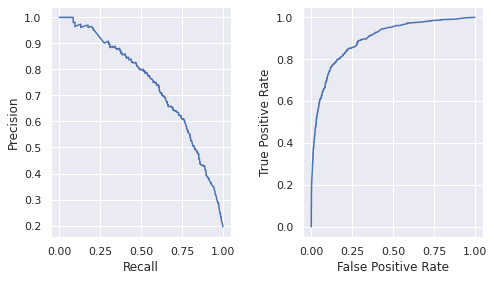

In [24]:
# random forest
rf = RandomForestClassifier(random_state=0) # testing model and visualize the data
r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc= check_scores(rf, x_train, x_test, y_train, y_test)

Train confusion matrix is: 
[[6824   31]
 [ 151 1649]]

Test confusion matrix is: 
[[2291   32]
 [ 296  267]]

              precision    recall  f1-score   support

           0       0.89      0.99      0.93      2323
           1       0.89      0.47      0.62       563

    accuracy                           0.89      2886
   macro avg       0.89      0.73      0.78      2886
weighted avg       0.89      0.89      0.87      2886


Train accuracy score:  0.9789716926632005
Test accuracy score:  0.8863478863478863

Train ROC-AUC score:  0.9969059080962801
Test ROC-AUC score:  0.9291951899645907

Are under Precision-Recall curve: 0.6194895591647333
Area under ROC-AUC: 0.8049968785115695


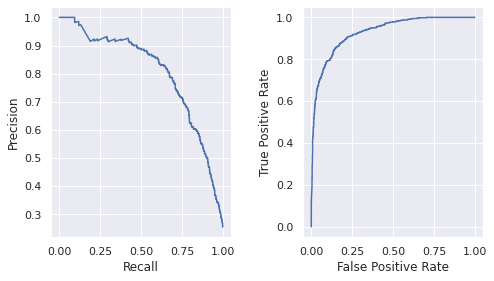

In [25]:
# svm
SVM = svm.SVC(probability=True) # testing model and visualize the data
s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc = check_scores(SVM, x_train, x_test, y_train, y_test)

In [26]:
# hyperparameter tuning 
parameters ={
    "C":[0.001, 0.1, 1, 10],
    "kernel":['linear', 'rbf', 'sigmoid', 'poly'],
    "gamma":['scale', 'auto']
}

In [27]:
# optimization with svm
svm_optimized = grid_search(svm.SVC(probability=True), parameters,x_train, y_train)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV] END ................C=0.001, gamma=scale, kernel=linear; total time=   5.0s
[CV] END ................C=0.001, gamma=scale, kernel=linear; total time=   5.0s
[CV] END ...................C=0.001, gamma=scale, kernel=rbf; total time=   5.6s
[CV] END ...................C=0.001, gamma=scale, kernel=rbf; total time=   5.7s
[CV] END ...............C=0.001, gamma=scale, kernel=sigmoid; total time=   5.2s
[CV] END ...............C=0.001, gamma=scale, kernel=sigmoid; total time=   5.2s
[CV] END ..................C=0.001, gamma=scale, kernel=poly; total time=   6.2s
[CV] END ..................C=0.001, gamma=scale, kernel=poly; total time=   6.2s
[CV] END .................C=0.001, gamma=auto, kernel=linear; total time=   5.0s
[CV] END .................C=0.001, gamma=auto, kernel=linear; total time=   5.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   4.9s
[CV] END ....................C=0.001, gamma=auto

Train confusion matrix is: 
[[6829   26]
 [   5 1795]]

Test confusion matrix is: 
[[2272   51]
 [ 245  318]]

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2323
           1       0.86      0.56      0.68       563

    accuracy                           0.90      2886
   macro avg       0.88      0.77      0.81      2886
weighted avg       0.89      0.90      0.89      2886


Train accuracy score:  0.996418255343732
Test accuracy score:  0.8974358974358975

Train ROC-AUC score:  0.9987310154793744
Test ROC-AUC score:  0.9287593598343539

Are under Precision-Recall curve: 0.6824034334763949
Area under ROC-AUC: 0.8075638062443496


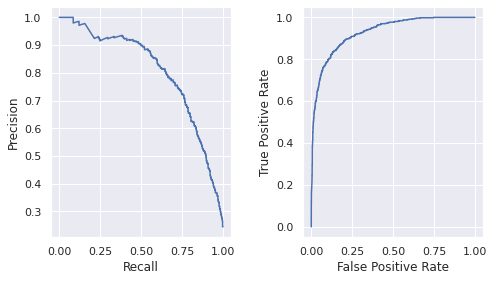

In [28]:
# showing score and visualize the data
so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc = check_scores(svm_optimized,x_train, x_test, y_train, y_test) 

In [29]:
# showing all model accuracy
data = [('Artificial Neural Network',train_acc_NN, test_acc_NN, train_roc_NN, test_roc_NN),
        ('Multinomial Naive Bayes',m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc),
        ('Random Forest', r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc),
        ('SVM', s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc),
        ('SVM Optimized', so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc)]


Scores_ =pd.DataFrame(data = data, columns=['Model Name','Train Accuracy', 'Test Accuracy', 'Train ROC', 'Test ROC'])
Scores_.set_index('Model Name', inplace = True)

Scores_

,Train Accuracy,Test Accuracy,Train ROC,Test ROC
Model Name,,,,
Artificial Neural Network,0.807378,0.813745,0.568251,0.570823
Multinomial Naive Bayes,0.850029,0.834026,0.956111,0.901301
Random Forest,0.996418,0.880111,0.998244,0.895687
SVM,0.978972,0.886348,0.996906,0.929195
SVM Optimized,0.996418,0.897436,0.998731,0.928759
